# Target-embedding autoencoders

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader

from data.skl_synthetic import *
from models.linear import LinearMLP, LinearAE, LinearFEA

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

### Load data, set model paramaters 

In [3]:
home = Path.home()
path_for_data = home/"teas-data/sklearn/"
if not os.path.exists(path_for_data):
    make_skl_dataset()
if os.path.exists(path_for_data):
    X_train, X_valid, X_test, Y_train, Y_valid, Y_test = map(FloatTensor, load_skl_data(path_for_data))

In [4]:
batch_size = 128
train_ds = TensorDataset(X_train, Y_train)
valid_ds = TensorDataset(X_valid, Y_valid)
test_ds = TensorDataset(X_test, Y_test)
train_dl = DataLoader(train_ds, batch_size)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [13]:
# these give us some shape values for later
X, Y = next(iter(train_ds))
input_dim = X.shape[0]
hidden_dim = 128
output_dim = Y.shape[0]

### First, train a simple linear autoencoder *for Y*

In [14]:
lae_model = LinearAE(output_dim, hidden_dim)
lae_model

LinearAE(
  (input): Linear(in_features=1000, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1000, bias=True)
)

In [16]:
# train the linear AE
epochs = 30
lr = 5e-4
opt = optim.Adam(lae_model.parameters(), lr)
# opt = optim.SGD(lae_model.parameters(), lr)

mse = nn.MSELoss()
train_loss, valid_loss = [], []

In [17]:
# lrs = scale_lr(5e-4, 5e-4, epochs)
for e in tqdm(range(epochs)):
#     opt = optim.Adam(lae_model.parameters(), lrs[e])
    this_train_loss = np.mean([lae_model.update_batch(Y, opt, mse) for _, Y in train_dl])
    this_valid_loss = np.mean([lae_model.update_batch(Y, opt, mse, train=False) for _, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


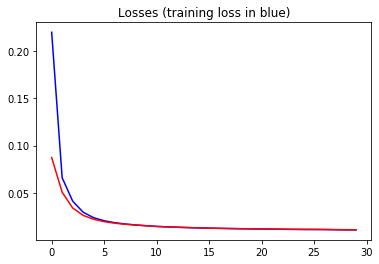

In [18]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Final validation loss (predict Y from Y)

In [19]:
print("Final valid loss: {}".format(valid_loss[-1]))

Final valid loss: 0.010766220395453274


### Visualise predicted vs. actual

In [20]:
# pick a row, generate predictions
idx = 10
X, Y = valid_ds[idx]
# Y_hat, X_tilde = lfea_model(X)
Y_tilde = lae_model(Y)

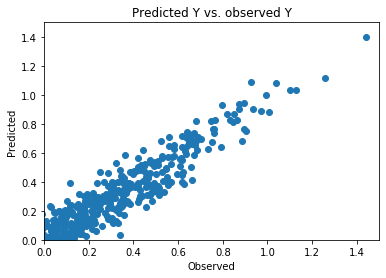

In [21]:
# Y_tilde vs. Y
plt.scatter(Y.detach().numpy(), Y_tilde.detach().numpy())
plt.title("Predicted Y vs. observed Y");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

### Now use these weights in a TEA

In [22]:
class LinearTEA(nn.Module):
    """A pytorch module to build a linear target-embedding autoencoder"""

    def __init__(self, input_dim=input_dim, hidden_dim = 256, output_dim=output_dim):
        """
        Parameters
        ----------
        input_dim : int
            The number of input features
        hidden_dim : int
            The number of features in the hidden layer
        output_dim : int
            The number of output features
        """
        super().__init__()
        self.input_X = nn.Linear(input_dim, hidden_dim)
        self.input_Y = nn.Linear(output_dim, hidden_dim)
        self.predict_Y = nn.Linear(hidden_dim, output_dim)
  
    def forward(self, X, Y):
        Z_from_X = self.input_X(X)
        Z_from_Y = self.input_Y(Y)
        Y_hat = self.predict_Y(Z_from_Y)
        return Y_hat, Z_from_Y, Z_from_X
    
    def predict_Y_from_X(self, X):
        """Make a prediction of Y from X only. For inference use."""
        Z_from_X = self.input_X(X)
        Y_hat = self.predict_Y(Z_from_X)
        return Y_hat
    
    def update_batch(self, X, Y, optimizer, criterion, train = True):
        """update_batch takes a model, data, a learning rate and a boolean indicating whether this update 
        should be treated as a training run (i.e. the model's weights should be updated) 
        or not.  

        Parameters
        ----------
        model : torch.nn.mnodule
            The model to be updated
        X : torch.FloatTensor
            The input data (i.e feature matrix)
        Y : torch.FloatTensor
            (The target matrix)
        train : bool
            Should the weights be updated (default = True)
        """
        Y_hat, Z, Z_hat = self.forward(X, Y)
        loss = criterion(Y, Y_hat, Z, Z_hat)
        if train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        return loss.item()

In [23]:
class joint_loss(nn.Module):
    """
    Parameters
    ----------
    lambda_ : float
        Weighting in the joint joss. 
        Higher lambda_ favours lower reconstruction loss.
    """
    def __init__(self, lambda_=0.5):
        super().__init__()
        self.X = X
        self.Y = Y
        self.lambda_ = lambda_
        
    def forward(self, Y, Y_hat, Z, Z_hat):
        mse = nn.MSELoss()
        return ( ((1 - self.lambda_) * mse(Y_hat, Y)) + (self.lambda_ * mse(Z_hat, Z)) )

In [86]:
ltea_model = LinearTEA(input_dim, hidden_dim, output_dim)
ltea_model

LinearTEA(
  (input_X): Linear(in_features=100, out_features=128, bias=True)
  (input_Y): Linear(in_features=1000, out_features=128, bias=True)
  (predict_Y): Linear(in_features=128, out_features=1000, bias=True)
)

### Copy the weights and biases from the trained AE

In [87]:
ltea_model.input_Y.load_state_dict(lae_model.input.state_dict(), strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [88]:
ltea_model.predict_Y.load_state_dict(lae_model.output.state_dict(), strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [80]:
# train the linear TEA
epochs = 3
lr = 1e-3
opt = optim.Adam(ltea_model.parameters(), lr)
criterion = joint_loss(lambda_= .5)
train_loss, valid_loss = [], []

In [81]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion) for X, Y in train_dl])
    this_valid_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


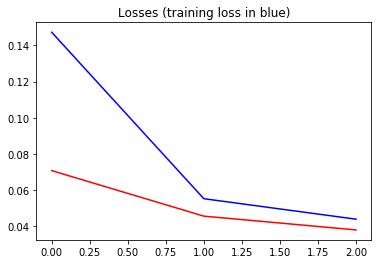

In [82]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Final validation loss on predicting Y from X

In [89]:
# validation losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in valid_ds:
    Y_hat = ltea_model.predict(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final validation MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final validation MSE loss on prediction task: 0.5839198231697083


Results for different values of lambda:

| Lambda   | Final validation loss |
| :------- | :------------------   |
| 0.00     | 0.5848469138145447    |
| 0.25     | 0.20141418278217316   |
| 0.50     | 0.1873609572649002    |
| 0.75     |     ||

The best performing model(s) favour Y_hat loss.

### Visualise predicted vs. actual

In [90]:
# pick a row, generate predictions
idx = 10
X, Y = test_ds[idx]
Y_hat_train, _, _ = ltea_model(X, Y)
Y_hat_infer = ltea_model.predict(X)

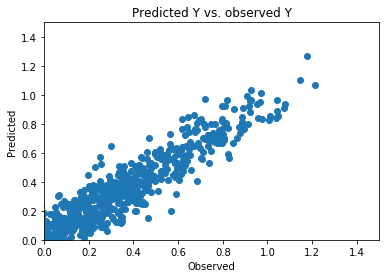

In [92]:
# Y_hat vs Y
plt.scatter(Y.detach().numpy(), Y_hat_train.detach().numpy())
plt.title("Predicted Y vs. observed Y");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

### Test loss 

In [ ]:
# test losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat, _ = lfea_model(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

In [ ]:
gc.collect()